In [2]:
import pandas as pd
import numpy as np
import cv2, os, shutil, math
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [34]:
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def make_dataframes(sdir):
    bad_images = []  # Giữ lại nếu có ảnh bị lỗi, nhưng không cần xử lý
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))  # Lấy danh sách các lớp bệnh (thư mục con)
    
    # Duyệt qua các thư mục bệnh
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        if not os.path.isdir(classpath):  # Nếu không phải thư mục thì bỏ qua
            continue
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        
        # Duyệt qua từng tệp trong thư mục
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            try:
                # Đọc ảnh mà không cần kiểm tra phần mở rộng
                img = cv2.imread(fpath)
                shape = img.shape  # Lấy kích thước ảnh
                filepaths.append(fpath)
                labels.append(klass)
            except Exception as e:
                bad_images.append(fpath)  # Lưu lại ảnh bị lỗi
                print(f'Defective image file: {fpath}, Error: {e}')
    
    # Tạo DataFrame từ danh sách filepaths và labels
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    
    # Chia dữ liệu thành train, validation và test (80-10-10)
    train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
    
    # Tính toán một số thông số về dữ liệu
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)
    
    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h, w = img.shape[:2]
            ht += h
            wt += w
            count += 1
        except:
            pass
    if count > 0:
        ave_height = ht // count
        ave_width = wt // count
        aspect_ratio = ave_height / ave_width
    else:
        ave_height, ave_width, aspect_ratio = 0, 0, 0
    
    # Hiển thị thông tin thống kê
    print(f'Number of classes in processed dataset: {class_count}')
    counts = list(train_df['labels'].value_counts())
    print(f'Max files in any class in train_df: {max(counts)}, Min files in any class: {min(counts)}')
    print(f'Train dataset length: {len(train_df)}, Test dataset length: {len(test_df)}, Validation dataset length: {len(valid_df)}')
    print(f'Average image height: {ave_height}, Average image width: {ave_width}, Aspect ratio (height/width): {aspect_ratio}')
    
    return train_df, test_df, valid_df, classes, class_count

# Đọc và chia dữ liệu
sdir = 'D:/2011/folder1'  # Đường dẫn tới thư mục ảnh
train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)


scab                   : 100%|██████████████████████████████████████████| 3673/3673 [04:26<00:00, 13.78file/s]


Number of classes in processed dataset: 6
Max files in any class in train_df: 2938, Min files in any class: 947
Train dataset length: 11988, Test dataset length: 1499, Validation dataset length: 1498
Average image height: 1757, Average image width: 2584, Aspect ratio (height/width): 0.679953560371517


In [35]:
n=2500
batch_size = 32
working_dir=r'./'
img_size=(300, 300)
epochs = 50
input_shape = (300, 300, 3)


def balance(df, n, working_dir, img_size):
    df = df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)

    for label in df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)
    total = 0
    gen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,  # Thêm shear
    fill_mode='reflect',  # Thay đổi từ 'nearest' sang 'reflect'
    brightness_range=[0.8, 1.2],  # Thêm brightness augmentation
    channel_shift_range=50.0,  # Thêm channel shift
    validation_split=0.2
    )
    groups = df.groupby('labels')
    for label in df['labels'].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        if sample_count < n:
            aug_img_count = 0
            delta = n - sample_count
            target_dir = os.path.join(aug_dir, label)
            msg = '{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='')  # prints over on the same line
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=img_size,
                                              class_mode=None, batch_size=batch_size, shuffle=False,
                                              save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count
    print('Total Augmented images created= ', total)
    aug_fpaths, aug_labels = [], []
    classlist = os.listdir(aug_dir)
    for target in classlist:
        classpath = os.path.join(aug_dir, target)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(target)
    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name='labels')
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is ', len(df))
    return df


train_df = balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  11988
Found 2001 validated image filenames.    for class              rust              creating  499  augmented images 
Found 2368 validated image filenames.    for class            healthy             creating  132  augmented images 
Found 947 validated image filenames.     for class         powdery_mildew         creating 1553  augmented images 
Found 1189 validated image filenames.    for class           Black Rot            creating 1311  augmented images 
Total Augmented images created=  3544
Length of augmented dataframe is  15532


In [36]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen = ImageDataGenerator()
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=True)[0]
    test_steps = int(test_len / test_batch_size)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', batch_size=batch_size, shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count = len(classes)
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    return train_ds, test_ds, valid_ds

train_ds, test_ds, valid_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 15532 validated image filenames belonging to 6 classes.          for train generator 
Found 1498 validated image filenames belonging to 6 classes.           for valid generator 
Found 1499 validated image filenames belonging to 6 classes.           for test generator 
test batch size:  1 test steps:  1499 number of classes :  6


In [37]:
def h_sigmoid(x):
    res = tf.nn.relu6(x + 3) / 6
    return res

def h_swish(x):
    res = x * h_sigmoid(x)
    return res


class SEBlock(tf.keras.layers.Layer):
    def __init__(self, input_channels, r=16):
        super(SEBlock, self).__init__()
        self.P1 = GlobalAveragePooling2D()
        self.D1 = Dense(input_channels // r)
        self.A1 = Activation('relu')
        self.D2 = Dense(input_channels)


    def call(self, inputs, **kwargs):
        branch = self.P1(inputs)
        branch = self.D1(branch)
        branch = self.A1(branch)
        branch = self.D2(branch)
        branch = h_sigmoid(branch)
        branch = tf.expand_dims(input=branch, axis=1)
        branch = tf.expand_dims(input=branch, axis=1)
        y = inputs * branch
        return y


class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, in_size, exp_size, out_size, s, is_se_existing, NL, k):
        super(BottleNeck, self).__init__()
        self.stride = s
        self.in_size = in_size
        self.out_size = out_size
        self.is_se_existing = is_se_existing
        self.NL = NL

        self.C1 = Conv2D(filters=exp_size, kernel_size=(1, 1), strides=1, padding='same')
        self.B1 = BatchNormalization()

        self.DWC1 = DepthwiseConv2D(kernel_size=(k, k), strides=s, padding='same')
        self.B2 = BatchNormalization()

        self.se = SEBlock(input_channels=exp_size)
        self.C2 = Conv2D(filters=out_size, kernel_size=(1, 1), strides=1, padding='same')
        self.B3 = BatchNormalization()
        self.linear = Activation(tf.keras.activations.linear)

    def call(self, inputs, training=None, **kwargs):
        x = self.C1(inputs)
        x = self.B1(x, training=training)

        if self.NL == 'HS':
            x = h_swish(x)
        elif self.NL == 'RE':
            x = tf.nn.relu6(x)

        x = self.DWC1(x)
        x = self.B2(x, training=training)

        if self.NL == 'HS':
            x = h_swish(x)
        elif self.NL == 'RE':
            x = tf.nn.relu6(x)

        if self.is_se_existing:
            x = self.se(x)

        x = self.C2(x)
        x = self.B3(x)
        y = self.linear(x)

        if self.stride == 1 and self.in_size == self.out_size:
            y = add([y, inputs])
        return y

In [38]:
class MobileNetV3Small(tf.keras.layers.Layer):
    def __init__(self, input_shape):
        super(MobileNetV3Small, self).__init__()
        self.C1 = Conv2D(filters=16, kernel_size=(3, 3), strides=2, padding="same", input_shape=input_shape)
        self.B1 = BatchNormalization()
        self.bneck1 = BottleNeck(in_size=16, exp_size=16, out_size=16, s=2, is_se_existing=True, NL="RE", k=3)
        self.bneck2 = BottleNeck(in_size=16, exp_size=72, out_size=24, s=2, is_se_existing=False, NL="RE", k=3)
        self.bneck3 = BottleNeck(in_size=24, exp_size=88, out_size=24, s=1, is_se_existing=False, NL="RE", k=3)
        self.bneck4 = BottleNeck(in_size=24, exp_size=96, out_size=40, s=2, is_se_existing=True, NL="HS", k=5)
        self.bneck5 = BottleNeck(in_size=40, exp_size=240, out_size=40, s=1, is_se_existing=True, NL="HS", k=5)
        self.bneck6 = BottleNeck(in_size=40, exp_size=240, out_size=40, s=1, is_se_existing=True, NL="HS", k=5)
        self.bneck7 = BottleNeck(in_size=40, exp_size=120, out_size=48, s=1, is_se_existing=True, NL="HS", k=5)
        self.bneck8 = BottleNeck(in_size=48, exp_size=144, out_size=48, s=1, is_se_existing=True, NL="HS", k=5)
        self.bneck9 = BottleNeck(in_size=48, exp_size=288, out_size=96, s=2, is_se_existing=True, NL="HS", k=5)
        self.bneck10 = BottleNeck(in_size=96, exp_size=576, out_size=96, s=1, is_se_existing=True, NL="HS", k=5)
        self.bneck11 = BottleNeck(in_size=96, exp_size=576, out_size=96, s=1, is_se_existing=True, NL="HS", k=5)

        self.C2 = Conv2D(filters=576,
                            kernel_size=(1, 1),
                            strides=1,
                            padding="same")
        self.B2 = BatchNormalization()
        self.P1 = AveragePooling2D(pool_size=(7, 7), strides=1)

        self.C3 = Conv2D(filters=1280, kernel_size=(1, 1), strides=1, padding="same")

        self.C4 = Conv2D(filters=1024, kernel_size=(1, 1), strides=1, padding="same", activation='softmax')

        self.P2 = GlobalAveragePooling2D()
        

    def call(self, inputs, training=None, mask=None):
        x = self.C1(inputs)
        x = self.B1(x, training=training)
        x = h_swish(x)

        x = self.bneck1(x, training=training)
        x = self.bneck2(x, training=training)
        x = self.bneck3(x, training=training)
        x = self.bneck4(x, training=training)
        x = self.bneck5(x, training=training)
        x = self.bneck6(x, training=training)
        x = self.bneck7(x, training=training)
        x = self.bneck8(x, training=training)
        x = self.bneck9(x, training=training)
        x = self.bneck10(x, training=training)
        x = self.bneck11(x, training=training)

        x = self.C2(x)
        x = self.B2(x, training=training)
        x = h_swish(x)
        x = self.P1(x)
        x = self.C3(x)
        x = h_swish(x)
        x = self.C4(x)
        y = self.P2(x)
        return y

In [39]:
def GELU(x):
    res = 0.5 * x * (1 + tf.nn.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * (x ** 3))))
    return res


# 定义残差MLP结构块
class ResMLPBlock(tf.keras.layers.Layer):
    def __init__(self, units, residual_path):
        super(ResMLPBlock, self).__init__()
        self.residual_path = residual_path
        self.D1 = Dense(units, activation='relu')
        self.D2 = Dense(units, activation='relu')

        if self.residual_path:
            self.D3 = Dense(units)
            self.D4 = Dense(units)

    def call(self, inputs):
        residual = inputs

        x = self.D1(inputs)
        y = self.D2(x)

        if self.residual_path:
            residual = self.D3(inputs)
            residual = GELU(residual)
            residual = self.D4(residual)
            residual = GELU(residual)

        output = y + residual
        return output


# ResMLP网络结构
class ResMLP(tf.keras.layers.Layer):
    def __init__(self, initial_filters, block_list, num_classes):
        super(ResMLP, self).__init__()
        self.initial_filters = initial_filters
        self.block_list = block_list

        self.D1 = Dense(self.initial_filters, activation='relu')
        self.B1 = BatchNormalization()

        self.blocks = tf.keras.models.Sequential()
        for block_id in range(len(block_list)):
            for layer_id in range(block_list[block_id]):
                if block_id != 0 and layer_id == 0:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=True)
                else:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=False)
                self.blocks.add(block)
            self.initial_filters *= 2

        self.D2 = Dense(num_classes, activation='softmax')


    def call(self, inputs):
        x = self.D1(inputs)
        x = self.B1(x)
        x = self.blocks(x)
        y = self.D2(x)
        return y

In [40]:
class NeuralNetwork(tf.keras.Model):
    def __init__(self, input_shape, initial_filters, block_list, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = MobileNetV3Small(input_shape=input_shape)
        self.layer2 = ResMLP(initial_filters=initial_filters, block_list=block_list, num_classes=num_classes)
        
    def call(self, x):
        x = self.layer1(x)
        y = self.layer2(x)
        return y

In [41]:
net = NeuralNetwork(input_shape=input_shape, initial_filters=32, block_list=[2, 2, 2], num_classes=6)

# Thêm accuracy vào metrics
net.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['AUC', 'accuracy'])  # Thêm 'accuracy' vào metrics

# checkpoint_save_path = './checkpoint/ResMLP.ckpt'
# if os.path.exists(checkpoint_save_path + '.index'):
#     print('-------------------------------------Loading-------------------------------------')
#     net.load_weights(checkpoint_save_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
#                               save_weights_only=True,
#                               save_best_only=True)

history = net.fit(train_ds, epochs=8, batch_size=batch_size, validation_data=valid_ds)

net.summary()


Epoch 1/8
486/486 [==============================] - 535s 1s/step - loss: 1.2847 - auc: 0.8224 - accuracy: 0.4722 - val_loss: 2.1077 - val_auc: 0.5773 - val_accuracy: 0.1362
Epoch 2/8
486/486 [==============================] - 421s 867ms/step - loss: 0.8766 - auc: 0.9226 - accuracy: 0.6702 - val_loss: 1.5476 - val_auc: 0.8294 - val_accuracy: 0.4726
Epoch 3/8
486/486 [==============================] - 431s 888ms/step - loss: 0.6389 - auc: 0.9582 - accuracy: 0.7604 - val_loss: 0.8153 - val_auc: 0.9388 - val_accuracy: 0.7170
Epoch 4/8
486/486 [==============================] - 414s 852ms/step - loss: 0.4853 - auc: 0.9752 - accuracy: 0.8121 - val_loss: 1.9178 - val_auc: 0.8209 - val_accuracy: 0.5487
Epoch 5/8
486/486 [==============================] - 410s 843ms/step - loss: 0.4382 - auc: 0.9793 - accuracy: 0.8338 - val_loss: 0.6112 - val_auc: 0.9650 - val_accuracy: 0.7817
Epoch 6/8
486/486 [==============================] - 420s 865ms/step - loss: 0.3600 - auc: 0.9857 - accuracy: 0.8691 -

Number of epochs: 5
Training loss data points: 8
Validation loss data points: 8
Mismatch in number of epochs and data points. Adjusting to match.


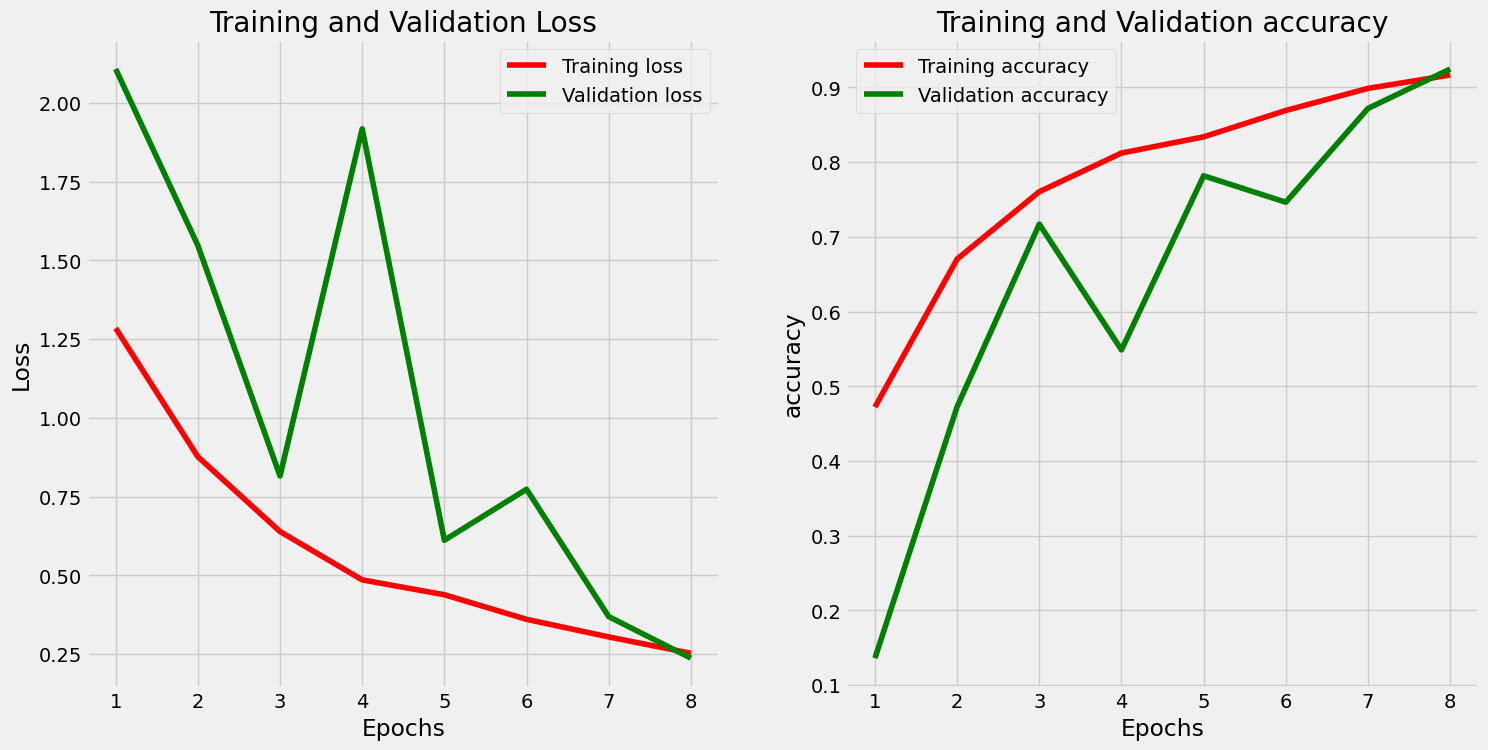

In [42]:
def plot_auc_loss(history, epochs):
    # Lấy dữ liệu từ history
    tloss = history.history['loss']  # Training loss
    vloss = history.history['val_loss']  # Validation loss

    # Kiểm tra và in ra số lượng phần tử trong các danh sách
    print(f"Number of epochs: {epochs}")
    print(f"Training loss data points: {len(tloss)}")
    print(f"Validation loss data points: {len(vloss)}")

    # Kiểm tra rằng số phần tử trong các list khớp với số epoch
    if len(tloss) != epochs or len(vloss) != epochs:
        print("Mismatch in number of epochs and data points. Adjusting to match.")
        epochs = min(len(tloss), len(vloss))  # Điều chỉnh lại epochs nếu có sự khác biệt

    Epochs = range(1, epochs + 1)  # Tạo list Epochs có độ dài giống với loss

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    # Vẽ biểu đồ Training Loss và Validation Loss
    axes[0].plot(Epochs, tloss[:epochs], 'r', label='Training loss')  # Cắt phần tử phù hợp với số epoch
    axes[0].plot(Epochs, vloss[:epochs], 'g', label='Validation loss')  # Cắt phần tử phù hợp với số epoch
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Vẽ biểu đồ Accuracy nếu có
    if 'accuracy' in history.history:
        tacc = history.history['accuracy']
        vacc = history.history['val_accuracy']
        axes[1].plot(Epochs, tacc[:epochs], 'r', label='Training accuracy')  # Cắt phần tử phù hợp với số epoch
        axes[1].plot(Epochs, vacc[:epochs], 'g', label='Validation accuracy')  # Cắt phần tử phù hợp với số epoch
        axes[1].set_title('Training and Validation accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('accuracy')
        axes[1].legend()

    plt.show()

# Sử dụng hàm với số epochs bạn đã dùng để huấn luyện
plot_auc_loss(history, epochs=5)


47/47 [==============================] - 51s 1s/step
there were 139 errors in 1499 tests for an accuracy of  90.73%


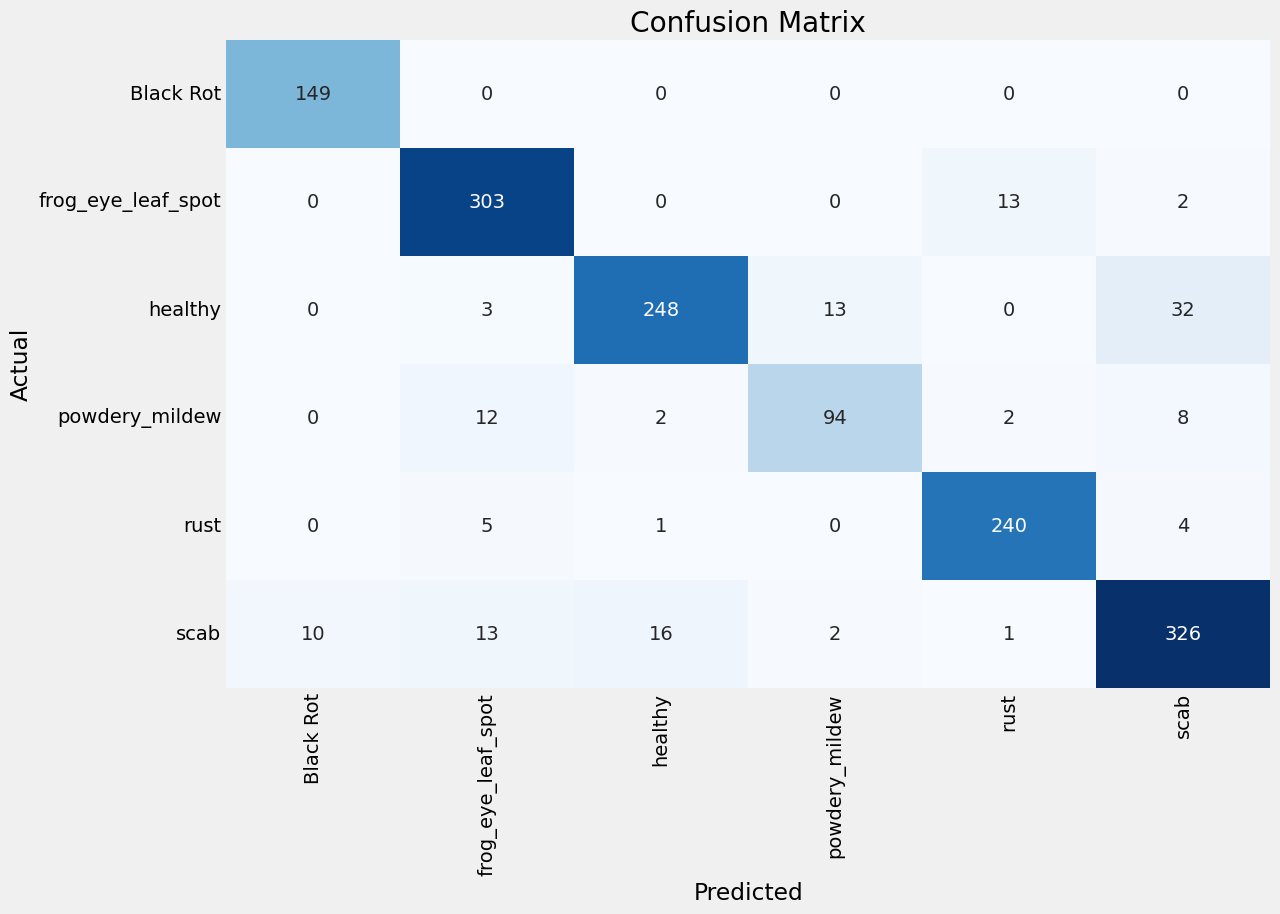

Classification Report:
----------------------
                     precision    recall  f1-score   support

         Black Rot     0.9371    1.0000    0.9675       149
frog_eye_leaf_spot     0.9018    0.9528    0.9266       318
           healthy     0.9288    0.8378    0.8810       296
    powdery_mildew     0.8624    0.7966    0.8282       118
              rust     0.9375    0.9600    0.9486       250
              scab     0.8763    0.8859    0.8811       368

          accuracy                         0.9073      1499
         macro avg     0.9073    0.9055    0.9055      1499
      weighted avg     0.9072    0.9073    0.9064      1499



In [50]:
def predictor(test_ds):
    y_pred, error_list, error_pred_list = [], [], []
    y_true = test_ds.labels
    classes = list(test_ds.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = tf.argmax(net.predict(test_ds), axis=1)
    tests = len(preds)
    for i in range(tests):
        pred_index = preds[i]
        true_index = test_ds.labels[i]
        if pred_index != true_index:
            errors += 1
            file = test_ds.filenames[i]
            error_list.append(file)
            error_classes = classes[pred_index]
            error_pred_list.append(error_classes)
        y_pred.append(pred_index)

    acc = (1 - errors / tests) * 100
    msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
    print(msg)
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score = predictor(test_ds)

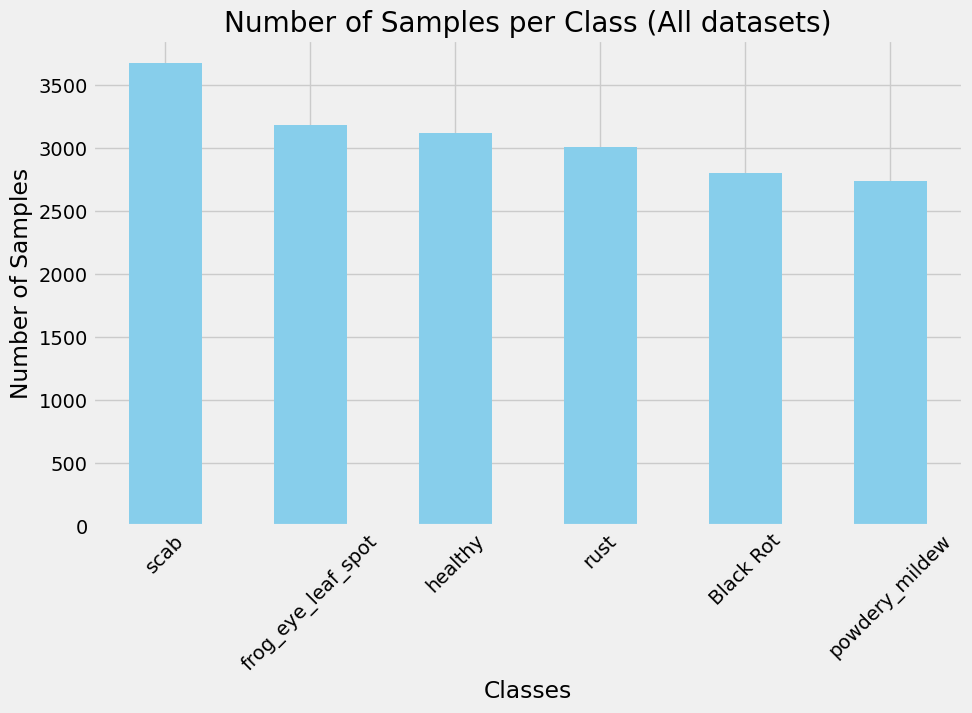

In [44]:
import matplotlib.pyplot as plt

# Kết hợp tất cả các DataFrame train, test, và validation
all_data = pd.concat([train_df, test_df, valid_df])

# Đếm số lượng mẫu cho mỗi lớp trong toàn bộ bộ dữ liệu
class_counts_all = all_data['labels'].value_counts()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
class_counts_all.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per Class (All datasets)')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()


In [45]:
# Lưu model dưới dạng SavedModel
saved_model_path = './model/mobilenetV3_resmlp'
net.save(saved_model_path, save_format='tf')
print(f"Model đã được lưu dưới dạng SavedModel tại: {saved_model_path}")

# Lưu model dưới dạng TFLite
tflite_save_path = './model/mobilenetV3_resmlp.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(net)
tflite_model = converter.convert()

with open(tflite_save_path, 'wb') as f:
    f.write(tflite_model)
print(f"Model đã được lưu dưới dạng TFLite tại: {tflite_save_path}")

INFO:tensorflow:Assets written to: ./model/mobilenetV3_resmlp\assets


INFO:tensorflow:Assets written to: ./model/mobilenetV3_resmlp\assets


Model đã được lưu dưới dạng SavedModel tại: ./model/mobilenetV3_resmlp


INFO:tensorflow:Assets written to: C:\Users\hyu\AppData\Local\Temp\tmpeg31fix8\assets


INFO:tensorflow:Assets written to: C:\Users\hyu\AppData\Local\Temp\tmpeg31fix8\assets


Model đã được lưu dưới dạng TFLite tại: ./model/mobilenetV3_resmlp.tflite


In [46]:
# Tải lại model đã lưu dưới dạng SavedModel
loaded_model = tf.keras.models.load_model('./model/mobilenetV3_resmlp')

# Kiểm tra cấu trúc model
loaded_model.summary()

# Chạy thử dự đoán trên một batch từ valid_ds
for batch in valid_ds:
    images, labels = batch
    predictions = loaded_model.predict(images)
    print("Predictions:", predictions)
    print("True Labels:", labels)
    break  # Chỉ chạy thử trên một batch

Model: "neural_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobile_net_v3_small_1 (Mobi  multiple                 2649783   
 leNetV3Small)                                                   
                                                                 
 res_mlp_1 (ResMLP)          multiple                  141478    
                                                                 
Total params: 2,791,261
Trainable params: 2,779,053
Non-trainable params: 12,208
_________________________________________________________________
1/1 [==============================] - 1s 893ms/step
Predictions: [[1.93508822e-05 9.90841269e-01 3.94032031e-05 1.25364488e-04
  8.81318655e-03 1.61389893e-04]
 [9.98017073e-01 3.06014299e-05 8.11317819e-04 4.31662120e-05
  1.00329670e-03 9.46001674e-05]
 [9.98017073e-01 3.06015754e-05 8.11326725e-04 4.31666231e-05
  1.00330194e-03 9.46009823e-05]
 [6.48617643e-

In [4]:
import subprocess

# Đường dẫn đến SavedModel đã lưu
saved_model_path = './model/mobilenetV3_resmlp'

# Đường dẫn thư mục để lưu model TensorFlow.js
tfjs_model_dir = './model/modeljs'

# Chuyển đổi model sang TensorFlow.js
result = subprocess.run([
    'tensorflowjs_converter',
    '--input_format', 'tf_saved_model',
    '--output_format', 'tfjs_graph_model',
    '--saved_model_tags', 'serve',
    saved_model_path,
    tfjs_model_dir
], capture_output=True, text=True)

if result.returncode != 0:
    print(f"Lỗi trong quá trình chuyển đổi: {result.stderr}")
else:
    print(f"Model đã được chuyển đổi sang TensorFlow.js và lưu tại: {tfjs_model_dir}")

Model đã được chuyển đổi sang TensorFlow.js và lưu tại: ./model/modeljs
